# Zac Wellmer's Project 1
# student id: 20363317
## Imports of utility functions we will be using
below we import the work for our residual network and deep hybrid scatter network. All the real 'heavy lifting' for this project was done in the resnet and ScatterTransform scripts. For a more detailed look at what's going on under the hood go give the scripts a peak.

In [1]:
import sys
import os
sys.path.append('/home/ubuntu/feature_viz/resnet')
sys.path.append('/home/ubuntu/feature_viz/ScatteringTransform/src/model')
from flags import define_flags as scatternet_define_flags
from train_mnist import train_model as scatternet_train
from res_features import train as resnet_train
from visualize import visualize_features
import sklearn
import tensorflow as tf

mnist = tf.contrib.learn.datasets.load_dataset("mnist")
x_test, y_test = mnist.test.next_batch(1280)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


# FEATURE EXTRACTION WITH RESIDUAL NETWORK AND FINE TUNING
## Resnet 50 pretrained from the Kth layer and higher
Below we generate two different pretrained residual networks. In both cases we generate a 50 layer residual network. The network variables are initialized with the values from a pretrained imagenet model. The difference between these two models is that one freezes weights before layer k while the other network leaves all variables as trainable. The inspiration behind this type of pretraining is because the initial layers of a CNN are learning features which are generally task invariant. As a result of this we make the assumption that the layers before K are "good enough" and our training should be spent on tuning the layers >= K.

In the case of both resnets we stack an additional 3 fully connected layers on top of the flattened previously generated features. The first 2 layers use recified linear units as activation functions followed by a final layer which uses a softmax. All 3 of these layers initialize weights with a uniform Xavier initializer. More information on the motivation behind Xavier initializers can be found [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

The purpose of the final 3 stacked fully connected layers is to generate logits for classification. These layers can be thought of as replacements to the final fully connected layers generating logits for the 1000 imagenet classes. In addition to a classification mismatch between imagenet and MNIST we do not take variables from these layers because they are far more task dependent.

In [2]:
resnet_classifier_k = resnet_train(freeze_before_k=3) # all blocks before block k are frozen for training
resnet_k_features_test = resnet_classifier_k.get_features(x_test)

tf.reset_default_graph() # clear graph for classifier_0
resnet_classifier_0 = resnet_train(freeze_before_k=0)
resnet_0_features_test = resnet_classifier_0.get_features(x_test)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/resnet_v1_50.ckpt
iter 0 train accuracy: 0.0703125
iter 100 test accuracy: 0.7599999904632568
EPOCH:  0
saving after 100 iterations
iter 100 train accuracy: 0.78125
iter 200 test accuracy: 0.7200000286102295
EPOCH:  0
saving after 200 iterations
iter 200 train accuracy: 0.8359375
iter 300 test accuracy: 0.8899999856948853
EPOCH:  0
saving after 300 iterations
iter 300 train accuracy: 0.8984375
iter 400 test accuracy: 0.8399999737739563
EPOCH:  0
saving after 400 iterations
iter 400 train accuracy: 0.8984375
iter 500 test accuracy: 0.9399999976158142
EPOCH:  1
saving after 500 iterations
iter 500 train accuracy: 0.9140625
iter 600 test accuracy: 0.8700000047683716
EPOCH:  1
s

iter 2400 test accuracy: 0.9700000286102295
EPOCH:  5
saving after 2400 iterations
iter 2400 train accuracy: 0.9921875
iter 2500 test accuracy: 0.9900000095367432
EPOCH:  5
saving after 2500 iterations
iter 2500 train accuracy: 0.9765625
iter 2600 test accuracy: 0.9800000190734863
EPOCH:  6
saving after 2600 iterations
iter 2600 train accuracy: 0.9921875
iter 2700 test accuracy: 0.9900000095367432
EPOCH:  6
saving after 2700 iterations
iter 2700 train accuracy: 0.9921875
iter 2800 test accuracy: 0.9900000095367432
EPOCH:  6
saving after 2800 iterations
iter 2800 train accuracy: 0.9921875
iter 2900 test accuracy: 0.9700000286102295
EPOCH:  6
saving after 2900 iterations
iter 2900 train accuracy: 1.0
iter 3000 test accuracy: 1.0
EPOCH:  6
saving after 3000 iterations
iter 3000 train accuracy: 0.984375
iter 3100 test accuracy: 1.0
EPOCH:  7
saving after 3100 iterations
iter 3100 train accuracy: 0.9921875
iter 3200 test accuracy: 1.0
EPOCH:  7
saving after 3200 iterations
iter 3200 train a

# FEATURE EXTRACTION WITH SCATTER NETWORK
## Scatternet Training and Testing on MNIST
The work for scatternet was mostly based off the work done by [tdeboissiere](https://github.com/tdeboissiere) found [here](https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/ScatteringTransform). This scatter network is actually a bit different than the scatter network found in Brunna & Mallat's work. What we analyze here is  a deep hybrid scatter network. We use scatter transforms similar to those found in [Brunna & Mallat's work](https://arxiv.org/abs/1203.1513) followed by a few convolutional layers and fully connected layers. A detailed explanation of how this works can be found in Oyallon's [Deep Hybrid Networks paper](https://arxiv.org/abs/1703.08961).

In [3]:
scatternet_define_flags() 
scatternet_classifier = scatternet_train()  # no pretrained weights for the hybrid scatter net so we do not need to specify a k


Setting up TF session:

Configuring directories:
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/logs
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/models
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/figures
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/logs
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/models
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/figures
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/train-images-idx3-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/train-labels-idx1-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/t10k-images-idx3-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Summary name HCNN/CONV2D/conv2d/w:0 is illegal; using HCNN/CONV2D/conv2d/w_0 instead.
INFO:tensorflow:Summary name HCNN/CONV2D/conv2d/b:0 is illegal; us

Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 0: - train loss: 2.32 val loss: 2.43 - train acc: 0.18 val acc: 0.11:   0%|          | 0/30 [00:03<?, ?it/s]
Epoch 0: - train loss: 2.32 val loss: 2.43 - train acc: 0.18 val acc: 0.11:   3%|▎         | 1/30 [00:03<01:37,  3.37s/it]
Epoch 0: - train loss: 2.40 val loss: 2.41 - train acc: 0.08 val acc: 0.15:   3%|▎         | 1/30 [00:03<01:47,  3.69s/it]
Epoch 0: - train loss: 2.37 val loss: 2.32 - train acc: 0.19 val acc: 0.15:   3%|▎         | 1/30 [00:03<01:55,  4.00s/it]
Epoch 0: - train loss: 2.37 val loss: 2.32 - train acc: 0.19 val acc: 0.15:  10%|█         | 3/30 [00:04<00:36,  1.33s/it]
Epoch 0: - train loss: 2.38 val loss: 2.31 - train acc: 0.12 val acc: 0.15:  10%|█         | 3/30 [00:04<00:38,  1.43s/it]
Epoch 0: - train loss: 2.35 val loss: 2.24 - train acc: 0.14 val acc: 0.20:  10%|█         | 3/30 [00:04<00:41,  1.53s/it]
Epoch 0: - train loss: 2.35 val loss: 2.24 - train acc: 0.14 val acc: 0.20:  17%|█▋        | 5/30 [

Epoch 1: - train loss: 2.06 val loss: 2.01 - train acc: 0.34 val acc: 0.45:  40%|████      | 12/30 [00:04<00:06,  2.87it/s]
Epoch 1: - train loss: 2.06 val loss: 2.01 - train acc: 0.34 val acc: 0.45:  47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]
Epoch 1: - train loss: 1.95 val loss: 1.99 - train acc: 0.45 val acc: 0.40:  47%|████▋     | 14/30 [00:04<00:05,  3.13it/s]
Epoch 1: - train loss: 1.96 val loss: 1.99 - train acc: 0.45 val acc: 0.41:  47%|████▋     | 14/30 [00:04<00:05,  2.94it/s]
Epoch 1: - train loss: 1.96 val loss: 1.99 - train acc: 0.45 val acc: 0.41:  53%|█████▎    | 16/30 [00:04<00:04,  3.36it/s]
Epoch 1: - train loss: 1.95 val loss: 1.94 - train acc: 0.38 val acc: 0.45:  53%|█████▎    | 16/30 [00:05<00:04,  3.17it/s]
Epoch 1: - train loss: 1.99 val loss: 1.93 - train acc: 0.40 val acc: 0.45:  53%|█████▎    | 16/30 [00:05<00:04,  2.99it/s]
Epoch 1: - train loss: 1.99 val loss: 1.93 - train acc: 0.40 val acc: 0.45:  60%|██████    | 18/30 [00:05<00:03,  3.36it/s]
Epoch 1:

Epoch 2: - train loss: 1.65 val loss: 1.58 - train acc: 0.77 val acc: 0.77:  87%|████████▋ | 26/30 [00:07<00:01,  3.26it/s]
Epoch 2: - train loss: 1.64 val loss: 1.68 - train acc: 0.70 val acc: 0.63:  87%|████████▋ | 26/30 [00:08<00:01,  3.14it/s]
Epoch 2: - train loss: 1.64 val loss: 1.68 - train acc: 0.70 val acc: 0.63:  93%|█████████▎| 28/30 [00:08<00:00,  3.38it/s]
Epoch 2: - train loss: 1.63 val loss: 1.63 - train acc: 0.70 val acc: 0.66:  93%|█████████▎| 28/30 [00:08<00:00,  3.26it/s]
Epoch 2: - train loss: 1.61 val loss: 1.59 - train acc: 0.75 val acc: 0.77:  93%|█████████▎| 28/30 [00:08<00:00,  3.16it/s]
Epoch 2: - train loss: 1.61 val loss: 1.59 - train acc: 0.75 val acc: 0.77: 100%|██████████| 30/30 [00:08<00:00,  3.38it/s]
Epoch 3:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 3: - train loss: 1.60 val loss: 1.60 - train acc: 0.70 val acc: 0.70:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 3: - train loss: 1.58 val loss: 1.61 - train acc: 0.70 val acc: 0.73:   0%|          | 

Epoch 4: - train loss: 1.31 val loss: 1.25 - train acc: 0.83 val acc: 0.91:  27%|██▋       | 8/30 [00:02<00:08,  2.75it/s]
Epoch 4: - train loss: 1.31 val loss: 1.25 - train acc: 0.83 val acc: 0.91:  33%|███▎      | 10/30 [00:02<00:05,  3.43it/s]
Epoch 4: - train loss: 1.30 val loss: 1.24 - train acc: 0.80 val acc: 0.88:  33%|███▎      | 10/30 [00:03<00:06,  3.12it/s]
Epoch 4: - train loss: 1.31 val loss: 1.26 - train acc: 0.84 val acc: 0.86:  33%|███▎      | 10/30 [00:03<00:07,  2.86it/s]
Epoch 4: - train loss: 1.31 val loss: 1.26 - train acc: 0.84 val acc: 0.86:  40%|████      | 12/30 [00:03<00:05,  3.42it/s]
Epoch 4: - train loss: 1.28 val loss: 1.39 - train acc: 0.84 val acc: 0.78:  40%|████      | 12/30 [00:03<00:05,  3.17it/s]
Epoch 4: - train loss: 1.23 val loss: 1.26 - train acc: 0.87 val acc: 0.89:  40%|████      | 12/30 [00:04<00:06,  2.94it/s]
Epoch 4: - train loss: 1.23 val loss: 1.26 - train acc: 0.87 val acc: 0.89:  47%|████▋     | 14/30 [00:04<00:04,  3.43it/s]
Epoch 4: 

Epoch 5: - train loss: 1.05 val loss: 1.03 - train acc: 0.85 val acc: 0.86:  73%|███████▎  | 22/30 [00:06<00:02,  3.20it/s]
Epoch 5: - train loss: 1.03 val loss: 1.01 - train acc: 0.87 val acc: 0.88:  73%|███████▎  | 22/30 [00:07<00:02,  3.07it/s]
Epoch 5: - train loss: 1.03 val loss: 1.01 - train acc: 0.87 val acc: 0.88:  80%|████████  | 24/30 [00:07<00:01,  3.35it/s]
Epoch 5: - train loss: 0.99 val loss: 0.95 - train acc: 0.89 val acc: 0.88:  80%|████████  | 24/30 [00:07<00:01,  3.22it/s]
Epoch 5: - train loss: 1.05 val loss: 0.98 - train acc: 0.88 val acc: 0.90:  80%|████████  | 24/30 [00:07<00:01,  3.09it/s]
Epoch 5: - train loss: 1.05 val loss: 0.98 - train acc: 0.88 val acc: 0.90:  87%|████████▋ | 26/30 [00:07<00:01,  3.34it/s]
Epoch 5: - train loss: 1.02 val loss: 0.99 - train acc: 0.88 val acc: 0.91:  87%|████████▋ | 26/30 [00:08<00:01,  3.22it/s]
Epoch 5: - train loss: 0.90 val loss: 1.08 - train acc: 0.94 val acc: 0.81:  87%|████████▋ | 26/30 [00:08<00:01,  3.11it/s]
Epoch 5:

Epoch 7: - train loss: 0.79 val loss: 0.77 - train acc: 0.91 val acc: 0.89:  13%|█▎        | 4/30 [00:01<00:11,  2.25it/s]
Epoch 7: - train loss: 0.79 val loss: 0.77 - train acc: 0.91 val acc: 0.89:  20%|██        | 6/30 [00:01<00:07,  3.37it/s]
Epoch 7: - train loss: 0.81 val loss: 0.78 - train acc: 0.89 val acc: 0.88:  20%|██        | 6/30 [00:02<00:08,  2.87it/s]
Epoch 7: - train loss: 0.83 val loss: 0.73 - train acc: 0.90 val acc: 0.93:  20%|██        | 6/30 [00:02<00:09,  2.51it/s]
Epoch 7: - train loss: 0.83 val loss: 0.73 - train acc: 0.90 val acc: 0.93:  27%|██▋       | 8/30 [00:02<00:06,  3.35it/s]
Epoch 7: - train loss: 0.79 val loss: 0.77 - train acc: 0.90 val acc: 0.88:  27%|██▋       | 8/30 [00:02<00:07,  2.96it/s]
Epoch 7: - train loss: 0.79 val loss: 0.74 - train acc: 0.91 val acc: 0.91:  27%|██▋       | 8/30 [00:02<00:08,  2.67it/s]
Epoch 7: - train loss: 0.79 val loss: 0.74 - train acc: 0.91 val acc: 0.91:  33%|███▎      | 10/30 [00:02<00:05,  3.34it/s]
Epoch 7: - trai

Epoch 8: - train loss: 0.66 val loss: 0.70 - train acc: 0.88 val acc: 0.88:  60%|██████    | 18/30 [00:05<00:03,  3.15it/s]
Epoch 8: - train loss: 0.65 val loss: 0.60 - train acc: 0.94 val acc: 0.93:  60%|██████    | 18/30 [00:05<00:03,  3.00it/s]
Epoch 8: - train loss: 0.65 val loss: 0.60 - train acc: 0.94 val acc: 0.93:  67%|██████▋   | 20/30 [00:05<00:02,  3.33it/s]
Epoch 8: - train loss: 0.61 val loss: 0.62 - train acc: 0.91 val acc: 0.90:  67%|██████▋   | 20/30 [00:06<00:03,  3.18it/s]
Epoch 8: - train loss: 0.63 val loss: 0.67 - train acc: 0.91 val acc: 0.90:  67%|██████▋   | 20/30 [00:06<00:03,  3.04it/s]
Epoch 8: - train loss: 0.63 val loss: 0.67 - train acc: 0.91 val acc: 0.90:  73%|███████▎  | 22/30 [00:06<00:02,  3.34it/s]
Epoch 8: - train loss: 0.63 val loss: 0.61 - train acc: 0.94 val acc: 0.91:  73%|███████▎  | 22/30 [00:06<00:02,  3.20it/s]
Epoch 8: - train loss: 0.57 val loss: 0.56 - train acc: 0.94 val acc: 0.92:  73%|███████▎  | 22/30 [00:07<00:02,  3.07it/s]
Epoch 8:

Epoch 10: - train loss: 0.54 val loss: 0.51 - train acc: 0.95 val acc: 0.93:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 10: - train loss: 0.54 val loss: 0.51 - train acc: 0.95 val acc: 0.93:   7%|▋         | 2/30 [00:00<00:08,  3.40it/s]
Epoch 10: - train loss: 0.52 val loss: 0.53 - train acc: 0.94 val acc: 0.95:   7%|▋         | 2/30 [00:00<00:12,  2.21it/s]
Epoch 10: - train loss: 0.60 val loss: 0.44 - train acc: 0.86 val acc: 0.95:   7%|▋         | 2/30 [00:01<00:16,  1.67it/s]
Epoch 10: - train loss: 0.60 val loss: 0.44 - train acc: 0.86 val acc: 0.95:  13%|█▎        | 4/30 [00:01<00:07,  3.33it/s]
Epoch 10: - train loss: 0.48 val loss: 0.43 - train acc: 0.98 val acc: 0.95:  13%|█▎        | 4/30 [00:01<00:09,  2.68it/s]
Epoch 10: - train loss: 0.49 val loss: 0.50 - train acc: 0.92 val acc: 0.94:  13%|█▎        | 4/30 [00:01<00:11,  2.24it/s]
Epoch 10: - train loss: 0.49 val loss: 0.50 - train acc: 0.92 val acc: 0.94:  20%|██        | 6/30 [00:01<00:07,  3.36it/s]
Epoch 10: - trai

Epoch 11: - train loss: 0.48 val loss: 0.43 - train acc: 0.95 val acc: 0.92:  47%|████▋     | 14/30 [00:04<00:05,  3.10it/s]
Epoch 11: - train loss: 0.44 val loss: 0.36 - train acc: 0.94 val acc: 0.97:  47%|████▋     | 14/30 [00:04<00:05,  2.91it/s]
Epoch 11: - train loss: 0.44 val loss: 0.36 - train acc: 0.94 val acc: 0.97:  53%|█████▎    | 16/30 [00:04<00:04,  3.33it/s]
Epoch 11: - train loss: 0.51 val loss: 0.38 - train acc: 0.90 val acc: 0.97:  53%|█████▎    | 16/30 [00:05<00:04,  3.14it/s]
Epoch 11: - train loss: 0.44 val loss: 0.39 - train acc: 0.92 val acc: 0.94:  53%|█████▎    | 16/30 [00:05<00:04,  2.96it/s]
Epoch 11: - train loss: 0.44 val loss: 0.39 - train acc: 0.92 val acc: 0.94:  60%|██████    | 18/30 [00:05<00:03,  3.32it/s]
Epoch 11: - train loss: 0.45 val loss: 0.42 - train acc: 0.92 val acc: 0.94:  60%|██████    | 18/30 [00:05<00:03,  3.16it/s]
Epoch 11: - train loss: 0.48 val loss: 0.42 - train acc: 0.91 val acc: 0.93:  60%|██████    | 18/30 [00:05<00:03,  3.00it/s]


Epoch 12: - train loss: 0.38 val loss: 0.43 - train acc: 0.95 val acc: 0.93:  87%|████████▋ | 26/30 [00:08<00:01,  3.12it/s]
Epoch 12: - train loss: 0.38 val loss: 0.43 - train acc: 0.95 val acc: 0.93:  93%|█████████▎| 28/30 [00:08<00:00,  3.36it/s]
Epoch 12: - train loss: 0.38 val loss: 0.30 - train acc: 0.95 val acc: 0.97:  93%|█████████▎| 28/30 [00:08<00:00,  3.24it/s]
Epoch 12: - train loss: 0.41 val loss: 0.39 - train acc: 0.92 val acc: 0.94:  93%|█████████▎| 28/30 [00:08<00:00,  3.13it/s]
Epoch 12: - train loss: 0.41 val loss: 0.39 - train acc: 0.92 val acc: 0.94: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]
Epoch 13:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 13: - train loss: 0.42 val loss: 0.33 - train acc: 0.93 val acc: 0.95:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 13: - train loss: 0.32 val loss: 0.34 - train acc: 0.97 val acc: 0.96:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 13: - train loss: 0.32 val loss: 0.34 - train acc: 0.97 val acc: 0.96:   7%|▋         | 

Epoch 14: - train loss: 0.36 val loss: 0.33 - train acc: 0.96 val acc: 0.97:  33%|███▎      | 10/30 [00:03<00:06,  3.33it/s]
Epoch 14: - train loss: 0.27 val loss: 0.39 - train acc: 0.97 val acc: 0.90:  33%|███▎      | 10/30 [00:03<00:06,  3.04it/s]
Epoch 14: - train loss: 0.31 val loss: 0.37 - train acc: 0.95 val acc: 0.94:  33%|███▎      | 10/30 [00:03<00:07,  2.80it/s]
Epoch 14: - train loss: 0.31 val loss: 0.37 - train acc: 0.95 val acc: 0.94:  40%|████      | 12/30 [00:03<00:05,  3.35it/s]
Epoch 14: - train loss: 0.27 val loss: 0.32 - train acc: 0.96 val acc: 0.96:  40%|████      | 12/30 [00:03<00:05,  3.10it/s]
Epoch 14: - train loss: 0.34 val loss: 0.35 - train acc: 0.93 val acc: 0.96:  40%|████      | 12/30 [00:04<00:06,  2.88it/s]
Epoch 14: - train loss: 0.34 val loss: 0.35 - train acc: 0.93 val acc: 0.96:  47%|████▋     | 14/30 [00:04<00:04,  3.36it/s]
Epoch 14: - train loss: 0.35 val loss: 0.32 - train acc: 0.94 val acc: 0.95:  47%|████▋     | 14/30 [00:04<00:05,  3.15it/s]


Epoch 15: - train loss: 0.30 val loss: 0.23 - train acc: 0.95 val acc: 0.96:  73%|███████▎  | 22/30 [00:06<00:02,  3.17it/s]
Epoch 15: - train loss: 0.32 val loss: 0.29 - train acc: 0.95 val acc: 0.94:  73%|███████▎  | 22/30 [00:07<00:02,  3.03it/s]
Epoch 15: - train loss: 0.32 val loss: 0.29 - train acc: 0.95 val acc: 0.94:  80%|████████  | 24/30 [00:07<00:01,  3.31it/s]
Epoch 15: - train loss: 0.38 val loss: 0.25 - train acc: 0.93 val acc: 0.95:  80%|████████  | 24/30 [00:07<00:01,  3.18it/s]
Epoch 15: - train loss: 0.28 val loss: 0.27 - train acc: 0.95 val acc: 0.97:  80%|████████  | 24/30 [00:07<00:01,  3.06it/s]
Epoch 15: - train loss: 0.28 val loss: 0.27 - train acc: 0.95 val acc: 0.97:  87%|████████▋ | 26/30 [00:07<00:01,  3.32it/s]
Epoch 15: - train loss: 0.32 val loss: 0.24 - train acc: 0.92 val acc: 0.97:  87%|████████▋ | 26/30 [00:08<00:01,  3.19it/s]
Epoch 15: - train loss: 0.41 val loss: 0.31 - train acc: 0.93 val acc: 0.95:  87%|████████▋ | 26/30 [00:08<00:01,  3.08it/s]


Epoch 17: - train loss: 0.24 val loss: 0.23 - train acc: 0.96 val acc: 0.95:  13%|█▎        | 4/30 [00:01<00:11,  2.30it/s]
Epoch 17: - train loss: 0.24 val loss: 0.23 - train acc: 0.96 val acc: 0.95:  20%|██        | 6/30 [00:01<00:06,  3.45it/s]
Epoch 17: - train loss: 0.30 val loss: 0.23 - train acc: 0.94 val acc: 0.96:  20%|██        | 6/30 [00:02<00:08,  2.92it/s]
Epoch 17: - train loss: 0.24 val loss: 0.29 - train acc: 0.95 val acc: 0.96:  20%|██        | 6/30 [00:02<00:09,  2.56it/s]
Epoch 17: - train loss: 0.24 val loss: 0.29 - train acc: 0.95 val acc: 0.96:  27%|██▋       | 8/30 [00:02<00:06,  3.40it/s]
Epoch 17: - train loss: 0.19 val loss: 0.25 - train acc: 0.99 val acc: 0.96:  27%|██▋       | 8/30 [00:02<00:07,  3.00it/s]
Epoch 17: - train loss: 0.36 val loss: 0.29 - train acc: 0.91 val acc: 0.96:  27%|██▋       | 8/30 [00:02<00:08,  2.71it/s]
Epoch 17: - train loss: 0.36 val loss: 0.29 - train acc: 0.91 val acc: 0.96:  33%|███▎      | 10/30 [00:02<00:05,  3.38it/s]
Epoch 1

Epoch 18: - train loss: 0.24 val loss: 0.23 - train acc: 0.96 val acc: 0.95:  60%|██████    | 18/30 [00:05<00:03,  3.38it/s]
Epoch 18: - train loss: 0.22 val loss: 0.21 - train acc: 0.96 val acc: 0.97:  60%|██████    | 18/30 [00:05<00:03,  3.19it/s]
Epoch 18: - train loss: 0.26 val loss: 0.23 - train acc: 0.94 val acc: 0.98:  60%|██████    | 18/30 [00:05<00:03,  3.02it/s]
Epoch 18: - train loss: 0.26 val loss: 0.23 - train acc: 0.94 val acc: 0.98:  67%|██████▋   | 20/30 [00:05<00:02,  3.36it/s]
Epoch 18: - train loss: 0.28 val loss: 0.22 - train acc: 0.95 val acc: 0.97:  67%|██████▋   | 20/30 [00:06<00:03,  3.20it/s]
Epoch 18: - train loss: 0.26 val loss: 0.19 - train acc: 0.94 val acc: 0.98:  67%|██████▋   | 20/30 [00:06<00:03,  3.06it/s]
Epoch 18: - train loss: 0.26 val loss: 0.19 - train acc: 0.94 val acc: 0.98:  73%|███████▎  | 22/30 [00:06<00:02,  3.36it/s]
Epoch 18: - train loss: 0.24 val loss: 0.19 - train acc: 0.92 val acc: 0.97:  73%|███████▎  | 22/30 [00:06<00:02,  3.22it/s]


Epoch 20:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 20: - train loss: 0.25 val loss: 0.25 - train acc: 0.95 val acc: 0.94:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 20: - train loss: 0.21 val loss: 0.23 - train acc: 0.97 val acc: 0.95:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 20: - train loss: 0.21 val loss: 0.23 - train acc: 0.97 val acc: 0.95:   7%|▋         | 2/30 [00:00<00:08,  3.32it/s]
Epoch 20: - train loss: 0.22 val loss: 0.19 - train acc: 0.95 val acc: 0.98:   7%|▋         | 2/30 [00:00<00:12,  2.24it/s]
Epoch 20: - train loss: 0.23 val loss: 0.25 - train acc: 0.98 val acc: 0.95:   7%|▋         | 2/30 [00:01<00:16,  1.68it/s]
Epoch 20: - train loss: 0.23 val loss: 0.25 - train acc: 0.98 val acc: 0.95:  13%|█▎        | 4/30 [00:01<00:07,  3.35it/s]
Epoch 20: - train loss: 0.19 val loss: 0.18 - train acc: 0.98 val acc: 0.98:  13%|█▎        | 4/30 [00:01<00:09,  2.69it/s]
Epoch 20: - train loss: 0.26 val loss: 0.20 - train acc: 0.94 val acc: 0.97:  13%|█▎        | 4/30 

Epoch 21: - train loss: 0.21 val loss: 0.22 - train acc: 0.96 val acc: 0.96:  40%|████      | 12/30 [00:04<00:06,  2.91it/s]
Epoch 21: - train loss: 0.21 val loss: 0.22 - train acc: 0.96 val acc: 0.96:  47%|████▋     | 14/30 [00:04<00:04,  3.39it/s]
Epoch 21: - train loss: 0.28 val loss: 0.24 - train acc: 0.95 val acc: 0.96:  47%|████▋     | 14/30 [00:04<00:05,  3.17it/s]
Epoch 21: - train loss: 0.24 val loss: 0.23 - train acc: 0.97 val acc: 0.96:  47%|████▋     | 14/30 [00:04<00:05,  2.98it/s]
Epoch 21: - train loss: 0.24 val loss: 0.23 - train acc: 0.97 val acc: 0.96:  53%|█████▎    | 16/30 [00:04<00:04,  3.40it/s]
Epoch 21: - train loss: 0.20 val loss: 0.20 - train acc: 0.95 val acc: 0.98:  53%|█████▎    | 16/30 [00:04<00:04,  3.20it/s]
Epoch 21: - train loss: 0.25 val loss: 0.19 - train acc: 0.93 val acc: 0.95:  53%|█████▎    | 16/30 [00:05<00:04,  3.03it/s]
Epoch 21: - train loss: 0.25 val loss: 0.19 - train acc: 0.93 val acc: 0.95:  60%|██████    | 18/30 [00:05<00:03,  3.41it/s]


Epoch 22: - train loss: 0.20 val loss: 0.22 - train acc: 0.96 val acc: 0.95:  87%|████████▋ | 26/30 [00:07<00:01,  3.37it/s]
Epoch 22: - train loss: 0.24 val loss: 0.25 - train acc: 0.96 val acc: 0.95:  87%|████████▋ | 26/30 [00:08<00:01,  3.24it/s]
Epoch 22: - train loss: 0.21 val loss: 0.19 - train acc: 0.96 val acc: 0.98:  87%|████████▋ | 26/30 [00:08<00:01,  3.12it/s]
Epoch 22: - train loss: 0.21 val loss: 0.19 - train acc: 0.96 val acc: 0.98:  93%|█████████▎| 28/30 [00:08<00:00,  3.36it/s]
Epoch 22: - train loss: 0.20 val loss: 0.20 - train acc: 0.95 val acc: 0.95:  93%|█████████▎| 28/30 [00:08<00:00,  3.24it/s]
Epoch 22: - train loss: 0.23 val loss: 0.20 - train acc: 0.93 val acc: 0.95:  93%|█████████▎| 28/30 [00:08<00:00,  3.14it/s]
Epoch 22: - train loss: 0.23 val loss: 0.20 - train acc: 0.93 val acc: 0.95: 100%|██████████| 30/30 [00:08<00:00,  3.36it/s]
Epoch 23:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 23: - train loss: 0.18 val loss: 0.19 - train acc: 0.97 val acc: 0.96:

Epoch 24: - train loss: 0.19 val loss: 0.21 - train acc: 0.95 val acc: 0.96:  27%|██▋       | 8/30 [00:02<00:07,  2.97it/s]
Epoch 24: - train loss: 0.28 val loss: 0.20 - train acc: 0.94 val acc: 0.95:  27%|██▋       | 8/30 [00:02<00:08,  2.68it/s]
Epoch 24: - train loss: 0.28 val loss: 0.20 - train acc: 0.94 val acc: 0.95:  33%|███▎      | 10/30 [00:02<00:05,  3.35it/s]
Epoch 24: - train loss: 0.17 val loss: 0.15 - train acc: 0.97 val acc: 0.98:  33%|███▎      | 10/30 [00:03<00:06,  3.06it/s]
Epoch 24: - train loss: 0.13 val loss: 0.18 - train acc: 0.99 val acc: 0.97:  33%|███▎      | 10/30 [00:03<00:07,  2.81it/s]
Epoch 24: - train loss: 0.13 val loss: 0.18 - train acc: 0.99 val acc: 0.97:  40%|████      | 12/30 [00:03<00:05,  3.37it/s]
Epoch 24: - train loss: 0.22 val loss: 0.19 - train acc: 0.96 val acc: 0.95:  40%|████      | 12/30 [00:03<00:05,  3.12it/s]
Epoch 24: - train loss: 0.22 val loss: 0.16 - train acc: 0.95 val acc: 0.98:  40%|████      | 12/30 [00:04<00:06,  2.88it/s]
Ep

Epoch 25: - train loss: 0.16 val loss: 0.21 - train acc: 0.98 val acc: 0.94:  67%|██████▋   | 20/30 [00:06<00:03,  3.06it/s]
Epoch 25: - train loss: 0.16 val loss: 0.21 - train acc: 0.98 val acc: 0.94:  73%|███████▎  | 22/30 [00:06<00:02,  3.36it/s]
Epoch 25: - train loss: 0.23 val loss: 0.24 - train acc: 0.93 val acc: 0.96:  73%|███████▎  | 22/30 [00:06<00:02,  3.22it/s]
Epoch 25: - train loss: 0.15 val loss: 0.15 - train acc: 0.98 val acc: 0.97:  73%|███████▎  | 22/30 [00:07<00:02,  3.07it/s]
Epoch 25: - train loss: 0.15 val loss: 0.15 - train acc: 0.98 val acc: 0.97:  80%|████████  | 24/30 [00:07<00:01,  3.35it/s]
Epoch 25: - train loss: 0.20 val loss: 0.19 - train acc: 0.95 val acc: 0.98:  80%|████████  | 24/30 [00:07<00:01,  3.21it/s]
Epoch 25: - train loss: 0.18 val loss: 0.23 - train acc: 0.97 val acc: 0.95:  80%|████████  | 24/30 [00:07<00:01,  3.09it/s]
Epoch 25: - train loss: 0.18 val loss: 0.23 - train acc: 0.97 val acc: 0.95:  87%|████████▋ | 26/30 [00:07<00:01,  3.35it/s]


Epoch 27: - train loss: 0.20 val loss: 0.22 - train acc: 0.95 val acc: 0.95:  13%|█▎        | 4/30 [00:01<00:07,  3.38it/s]
Epoch 27: - train loss: 0.22 val loss: 0.21 - train acc: 0.95 val acc: 0.96:  13%|█▎        | 4/30 [00:01<00:09,  2.72it/s]
Epoch 27: - train loss: 0.12 val loss: 0.18 - train acc: 0.98 val acc: 0.96:  13%|█▎        | 4/30 [00:01<00:11,  2.24it/s]
Epoch 27: - train loss: 0.12 val loss: 0.18 - train acc: 0.98 val acc: 0.96:  20%|██        | 6/30 [00:01<00:07,  3.35it/s]
Epoch 27: - train loss: 0.18 val loss: 0.22 - train acc: 0.97 val acc: 0.95:  20%|██        | 6/30 [00:02<00:08,  2.89it/s]
Epoch 27: - train loss: 0.16 val loss: 0.23 - train acc: 0.98 val acc: 0.95:  20%|██        | 6/30 [00:02<00:09,  2.53it/s]
Epoch 27: - train loss: 0.16 val loss: 0.23 - train acc: 0.98 val acc: 0.95:  27%|██▋       | 8/30 [00:02<00:06,  3.38it/s]
Epoch 27: - train loss: 0.14 val loss: 0.24 - train acc: 0.97 val acc: 0.94:  27%|██▋       | 8/30 [00:02<00:07,  3.01it/s]
Epoch 27

Epoch 28: - train loss: 0.15 val loss: 0.13 - train acc: 0.98 val acc: 0.95:  53%|█████▎    | 16/30 [00:05<00:04,  3.13it/s]
Epoch 28: - train loss: 0.16 val loss: 0.13 - train acc: 0.98 val acc: 0.98:  53%|█████▎    | 16/30 [00:05<00:04,  2.96it/s]
Epoch 28: - train loss: 0.16 val loss: 0.13 - train acc: 0.98 val acc: 0.98:  60%|██████    | 18/30 [00:05<00:03,  3.33it/s]
Epoch 28: - train loss: 0.16 val loss: 0.24 - train acc: 0.95 val acc: 0.94:  60%|██████    | 18/30 [00:05<00:03,  3.16it/s]
Epoch 28: - train loss: 0.13 val loss: 0.28 - train acc: 0.98 val acc: 0.93:  60%|██████    | 18/30 [00:06<00:04,  2.99it/s]
Epoch 28: - train loss: 0.13 val loss: 0.28 - train acc: 0.98 val acc: 0.93:  67%|██████▋   | 20/30 [00:06<00:03,  3.32it/s]
Epoch 28: - train loss: 0.19 val loss: 0.16 - train acc: 0.95 val acc: 0.95:  67%|██████▋   | 20/30 [00:06<00:03,  3.16it/s]
Epoch 28: - train loss: 0.10 val loss: 0.14 - train acc: 0.99 val acc: 0.97:  67%|██████▋   | 20/30 [00:06<00:03,  3.01it/s]


Epoch 29: - train loss: 0.13 val loss: 0.11 - train acc: 0.96 val acc: 0.99:  93%|█████████▎| 28/30 [00:09<00:00,  3.11it/s]
Epoch 29: - train loss: 0.13 val loss: 0.11 - train acc: 0.96 val acc: 0.99: 100%|██████████| 30/30 [00:09<00:00,  3.33it/s]
Training progress: 100%|██████████| 30/30 [04:31<00:00,  9.05s/it]


Finished training!


# FEATURE VISUALIZATION
Sample some data points from MNIST to map to a feature space with both of our classifiers. Once we have both of these new feature spaces we can use TSNE to reduce dimensionality to a space easily visualized.

## TSNE on 50 layer residual network features
Looks like we are forming some clusters of each of the classes however there is some overlap. Multiple clusters are being formed for some of the classes. Some interesting future work could be a more in depth cluster analysis. There looks to be 2 different clusters for images representing 4s. Perhaps one cluster contains 4s that are straight while another could be slanted 4s. It coudl also be interesting to look at the images of the points which overlap between class clusters. Perhaps 4s and 9s are indeed quite similar. It is easy to visualize a 4 sloppily drawn to look very similar to a 9.

INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block3/mnist-4200


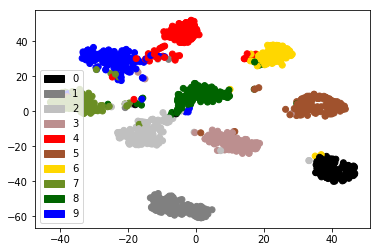

In [4]:
tf.reset_default_graph(); resnet_classifier_k.load() # have to save and load b/c of conflicting params between resnets

resnet_k_features_test = resnet_classifier_k.get_features(x_test)
visualize_features(resnet_k_features_test, y_test, 'resnet50_4')

## TSNE on unfrozen 50 layer residual network features
It appears that we generate far better separation between classes with the unfrozen residual network. I suspect that this is the case because the MNIST dataset did not impose a data constraint on us. However, if we were to significantly reduce access to data I suspect that the frozen residual network would provide better features. We still experience a cluster overlap between clusters albeit less than in the case of frozen weights.

INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block0/mnist-4200


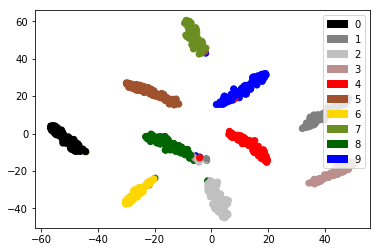

In [5]:
tf.reset_default_graph(); resnet_classifier_0.load() # have to save and load b/c of conflicting params between resnets\

resnet_0_features_test = resnet_classifier_0.get_features(x_test)
visualize_features(resnet_0_features_test, y_test, 'resnet50_0')

## TSNE on Deep Hybrid Network
Class separation is strong here but not quite as dense as we experienced in our 50 layer residual network. Perhaps this is because the deep hybrid network is far shallower than our 50 layer resnets.

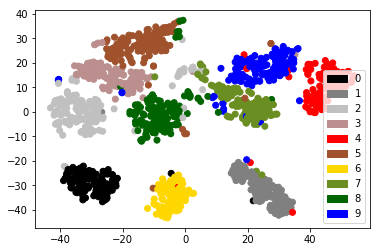

In [6]:
scatternet_features_test = scatternet_classifier.get_features(x_test)
visualize_features(scatternet_features_test, y_test, 'scatternet')

# IMAGE CLASSIFICATION


## train images and labels
collect a batch of training images we can use as a training set for the logistic regression models.

In [7]:
x_train, y_train = mnist.train.next_batch(1280)

## Multilayer Neural Network & Logistic Regression
The score function we use for comparison is just the mean number of labels correctly assigned to the test samples.

In [8]:
def logistic_regression(train_features, train_labels, test_features, test_labels):
    lm = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
    lm.fit(train_features, train_labels)
    score = lm.score(test_features, test_labels)
    return score

def NN_score(nn, x_test, test_labels):
    '''
    nn here either represents the resnet or hybrid scatter network. Here we call them to generate a mean accuracy
    
    we don't submit the same test features here because the network is deterministic and will generate the same
    intermediate features during the forward pass
    '''
    return nn.score(x_test, test_labels)
    

## Deep Hybrid Scatter Network: logistic regression vs fully connected neural network

In [9]:
scatternet_features_train = scatternet_classifier.get_features(x_train)

lm_scatternet_score = logistic_regression(scatternet_features_train, y_train, scatternet_features_test, y_test)
print('logistic regression on deep hybrid scatter network features accuracy: ', lm_scatternet_score)

nn_scatternet_score = NN_score(scatternet_classifier, x_test, y_test)
print('fully connected neural network stacked on scatter network features accuracy: ', nn_scatternet_score)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


logistic regression on deep hybrid scatter network features accuracy:  0.96875
fully connected neural network stacked on scatter network features accuracy:  0.9664062


## Frozen block K resnet: logistic regression vs fully connected neural network

In [10]:
tf.reset_default_graph(); resnet_classifier_k.load() # have to save and load b/c of conflicting params between resnets
resnet_k_features_train = resnet_classifier_k.get_features(x_train)

lm_res_k_score = logistic_regression(resnet_k_features_train, y_train, resnet_k_features_test, y_test)
print('logistic regression on frozen resnet features accuracy: ', lm_res_k_score)

nn_res_k_score = NN_score(resnet_classifier_k, x_test, y_test)
print('fully connected neural network stacked on frozen resnet features accuracy: ', nn_res_k_score)

INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block3/mnist-4200


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


logistic regression on frozen resnet features accuracy:  0.96015625
fully connected neural network stacked on frozen resnet features accuracy:  0.9429687


## Unfrozen resnet: logistic regression vs fully connected neural network

In [11]:
tf.reset_default_graph(); resnet_classifier_0.load() # have to save and load b/c of conflicting params between resnets
resnet_0_features_train = resnet_classifier_0.get_features(x_train)

lm_res_0_score = logistic_regression(resnet_0_features_train, y_train, resnet_0_features_test, y_test)
print('logistic regression on unfrozen resnet features accuracy: ', lm_res_0_score)

nn_res_0_score = NN_score(resnet_classifier_0, x_test, y_test)
print('fully connected neural network stacked on unfrozen resnet features accuracy: ', nn_res_0_score)

INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block0/mnist-4200


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


logistic regression on unfrozen resnet features accuracy:  0.98828125
fully connected neural network stacked on unfrozen resnet features accuracy:  0.98515624


# Results
In our analysis we compared 6 different types of classifiers. The 6 classifiers fell into a few different sub groups. First, the features were either generated from a 50 layer residual network or a deep hybrid network. Second The variables included in the 50 layer residual network were either frozen if they belonged to a layer earlier than K or they were initialized but left free to train. Third, the actual classification was done in one of two ways. The first choice of classification was using a basic multiclass logistic regression model. Our logistic regression model used saga for optimization. More information about saga can be read [here](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf) in a 2014 NIPs paper. The second choice of classification was using a multilayer fully connected neural network.

The frozen residual network and the deep hybrid network performed very similarly. It is unclear which of these two is actually supperior at this task. The Deep Hybrid Network performed marginally better, but hyperparams and preprocessing were optized for MNIST. While in the case of the residual network there was no preprocessing techniques used aside from copying gray scale representations to 3 channels to be compatible with pretrained imagenet weights. Hyperparameters were also left as default for the residual network. I am also unsure if any image preprocessing techniques were used when training the initialized residual network on imagenet. For example we did not apply mean shifting to mnist images and if mean shifting each channel was used during pretraining this could render the initialized weights less than useful.

The unfrozen residual network has come out as the clear champion for extracting features. We suspect that it trumps the frozen residual network because the task at hand does not have a data constraint which could incentivise us to concetrate our efforts on optimizing a subset of the weights.

Interestingly Our logistic regression classifier outperforms the multi-layer neural network. I suspect this is because the features generated in all cases(frozen resnet, unfrozen resnet, and deep hybrid network) are close to being linearly separable. The logistic regression classifier we use comes with some handy regularization techniques out of the box. I suspect that the reason the logistic regression classifier outperforms the neural network is because of these regularizers. The training error reached by the residual networks is extremely close to 1 while the test error plateus suggesting we may be overfitting to noise in the training data. Some interesting next steps to close this performance gap could be introducing l2 regularization on the weights, dropout, and some image augmentations.

Another interesting next piece of work would be to make a comparison between the features generated by a basic Scattering Convolutional Network with a Deep Hybrid Network.

The performance we reached in this paper was short of what others have reported online and in other papers. I suspect this has to do with our lack of regularizers, image augmentations, hyperparameter search, and a relatively short training time.

| Frozen Resnet LR | Frozen Resnet NN | Unfrozen Resnet LR | Unfrozen Resnet NN | Deep Hybrid Network LR | Deep Hybrid Network NN
------------ | ------------- | ------------- | ------------- | ------------- | ------------- |
test | 0.96015625 | 0.9429687 | 0.98828125 | 0.98515624 | 0.96875 | 0.9664062  